## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.linalg import norm
from pysal.lib.weights import Queen
from spint.gravity import Gravity, Production
from spopt import MaxPHeuristic, RegionKMeansHeuristic, WardSpatial, Skater

/home/thoffman/anaconda3/envs/gds/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def isCAres(x):
    # Vectorized evaluation if row is a CA to CA flow for residence column
    return np.array([el[:2] == '06' for el in x])

def isCAwork(x):
    # for work column
    return np.array([el[:3] == '006' for el in x])

In [3]:
# function to determine what region a county is in
def regionof(county, method): 
    return CAcdata.loc[CAcdata['county_name'] == county, f'{method}_labels'].iloc[0]

In [4]:
raw = pd.read_excel('../data/commuting_county2county20112015.xlsx', 
    converters={'Res_StateFIPS' : str, 'Res_CountyFIPS' : str, 'Work_StateFIPS' : str, 'Work_CountyFIPS' : str}).replace(
        np.nan, '000', regex=True)
CAcounties = gpd.read_file('../data/CAcounty_level_data.csv', GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
CAcounties['county_name'] = [x.replace(', California', '') for x in CAcounties['NAME']]

CAflows = raw[np.logical_and(isCAres(raw['Res_StateFIPS']), isCAwork(raw['Work_StateFIPS']))]

In [ ]:
# DO NOT RUN -- DEPRECATED -- current code just uses counties and flows dataframes
CAcdata = CAcounties.join(CAraw.set_index('Res_CountyFIPS'), on='county')

## Begin working with basic regionalization schemes at county level

In [5]:
# Convert cols to float
CAcounties['B00001_001E'] = CAcounties['B00001_001E'].values.astype(float)
CAcounties['B02001_002E'] = CAcounties['B02001_002E'].values.astype(float)
CAcounties['B07411_001E'] = CAcounties['B07411_001E'].values.astype(float)
CAflows['Flow'] = CAflows['Flow'].values.astype(float)

/home/thoffman/anaconda3/envs/gds/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [6]:
# Make spatial weights matrix
Wc = Queen.from_dataframe(CAcounties)

In [7]:
attrs = ['B07411_001E']  # 'B00001_001E' : total pop, 'B02001_002E' : total white people, 'B07411_001E' : median income
ward_model = WardSpatial(CAcounties, Wc, attrs, n_clusters=6)
ward_model.solve()
CAcounties['ward_labels'] = ward_model.labels_

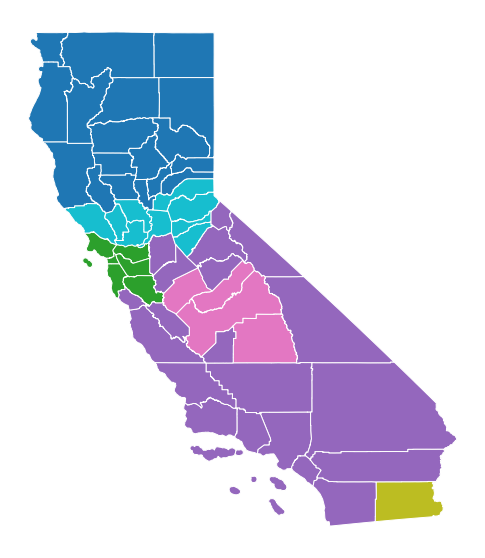

In [8]:
# Plot Ward linkage spatial clustering
fig, ax = plt.subplots(figsize=(10,10))
CAcounties.plot(column='ward_labels', categorical=True, ec='w', ax=ax)
plt.axis('off')
plt.savefig('cac_ward.png')

### Aggregate data by the regionalization

In [9]:
regdata = CAcounties.dissolve(by='ward_labels', aggfunc='mean')

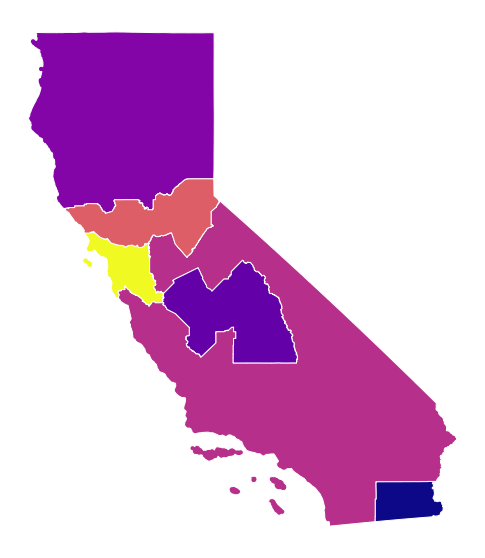

In [10]:
_, ax = plt.subplots(figsize=(10,10))
regdata.plot(column='B07411_001E', ec='w', cmap='plasma', ax=ax)
plt.axis('off')
plt.savefig('agg_ca_ward_income.png')

### Aggregate flows

In [11]:
CAcdata = CAflows.join(CAcounties.set_index('county'), on='Res_CountyFIPS')

In [12]:
# Manually aggregate flows

flows = np.zeros((CAcdata['ward_labels'].unique().shape[0], CAcdata['ward_labels'].unique().shape[0]))
for o in range(flows.shape[0]):
    # Locate all flows origininating in region i and going to different regions    
    for r in CAcdata.loc[CAcdata['ward_labels'] == o].iterrows():
        dest = regionof(r[1]['Work_County'], 'ward')
        if o != dest: flows[o, dest] += r[1]['Flow']

## Set up variables and fit Gravity model
(oh my god it works)

In [13]:
# use aggregated centroids to create costs in Euclidean distances (do this with a spatial weight?)
coords = np.hstack((regdata.centroid.x.values.reshape(-1, 1), regdata.centroid.y.values.reshape(-1, 1)))
o_coords = np.repeat(coords, coords.shape[0], axis=0)
d_coords = np.tile(coords, (coords.shape[0], 1))
cost = norm(o_coords - d_coords, axis=1)

In [14]:
# set o_vars and d_vars based on aggregated matrix
basevars = regdata[['B00001_001E', 'B02001_002E', 'B07411_001E']].astype(int).values
o_vars = np.repeat(basevars, basevars.shape[0], axis=0)
d_vars = np.tile(basevars, (basevars.shape[0], 1))

In [15]:
iflows = flows.astype(int).flatten()

In [16]:
model = Gravity(iflows, o_vars, d_vars, cost, 'exp')

In [17]:
model.params

array([-7.92909687e+01, -7.33408847e+00,  8.06469102e+00,  3.36410918e+00,
        2.05224524e-01,  1.63302726e-01,  2.45924863e+00, -7.49150609e-08])

In [19]:
print(f'AIC = {model.AIC}, SRMSE = {model.SRMSE}')

AIC = 532063.1976181583, SRMSE = 1.312208118812612


## Skater regionalization

In [20]:
attrs = ['B07411_001E']  # 'B00001_001E' : total pop, 'B02001_002E' : total white people, 'B07411_001E' : median income
skater_model = Skater(CAcounties, Wc, attrs, n_clusters=6)
skater_model.solve()
CAcounties['skater_labels'] = skater_model.labels_

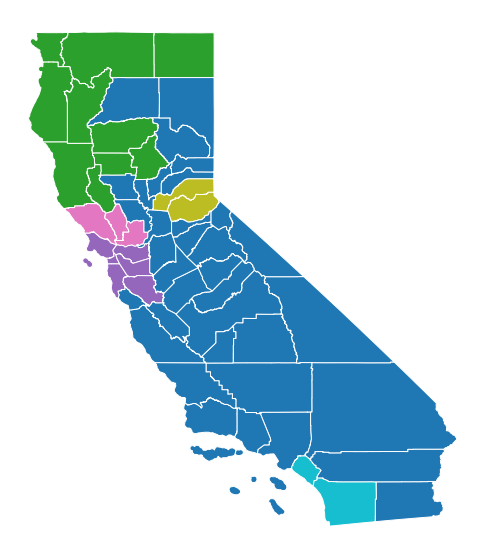

In [21]:
# Plot Skater spatial clustering
fig, ax = plt.subplots(figsize=(10,10))
CAcounties.plot(column='skater_labels', categorical=True, ec='w', ax=ax)
plt.axis('off')
plt.savefig('cac_skater.png')

In [22]:
skaterdata = CAcounties.dissolve(by='skater_labels', aggfunc='mean')

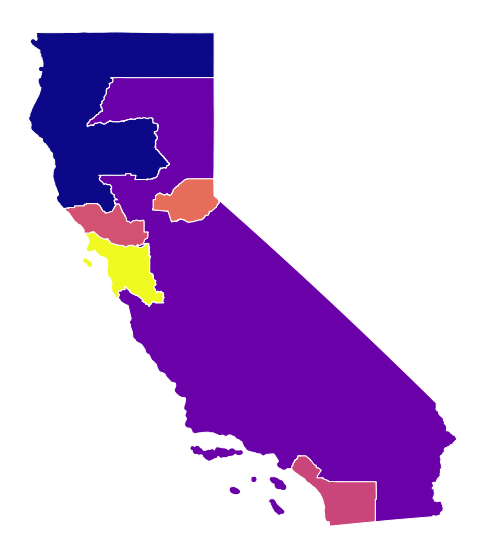

In [23]:
_, ax = plt.subplots(figsize=(10,10))
skaterdata.plot(column='B07411_001E', ec='w', cmap='plasma', ax=ax)
plt.axis('off')
plt.savefig('agg_ca_skater_income.png')

### Aggregate flows

In [24]:
CAcdata = CAflows.join(CAcounties.set_index('county'), on='Res_CountyFIPS')

In [25]:
# Manually aggregate flows

flows = np.zeros((CAcdata['skater_labels'].unique().shape[0], CAcdata['skater_labels'].unique().shape[0]))
for o in range(flows.shape[0]):
    # Locate all flows origininating in region i and going to different regions    
    for r in CAcdata.loc[CAcdata['skater_labels'] == o].iterrows():
        dest = regionof(r[1]['Work_County'], 'skater')
        if o != dest: flows[o, dest] += r[1]['Flow']

## Set up variables and fit Gravity model
(oh my god it works)

In [26]:
# use aggregated centroids to create costs in Euclidean distances (do this with a spatial weight?)
coords = np.hstack((skaterdata.centroid.x.values.reshape(-1, 1), skaterdata.centroid.y.values.reshape(-1, 1)))
o_coords = np.repeat(coords, coords.shape[0], axis=0)
d_coords = np.tile(coords, (coords.shape[0], 1))
cost = norm(o_coords - d_coords, axis=1)

In [27]:
# set o_vars and d_vars based on aggregated matrix
basevars = skaterdata[['B00001_001E', 'B02001_002E', 'B07411_001E']].astype(int).values
o_vars = np.repeat(basevars, basevars.shape[0], axis=0)
d_vars = np.tile(basevars, (basevars.shape[0], 1))

In [28]:
iflows = flows.astype(int).flatten()

In [29]:
model = Gravity(iflows, o_vars, d_vars, cost, 'exp')

In [30]:
model.params

array([ 7.22065685e+01,  1.79315320e+00, -1.00013126e+00, -4.53756324e+00,
        2.91262594e+00, -1.97169957e+00, -2.60298648e+00, -1.04179346e-06])

In [31]:
print(f'AIC = {model.AIC}, SRMSE = {model.SRMSE}')

AIC = 2181585.939565057, SRMSE = 2.693129862884207


## Regional k-means regionalization

In [32]:
kmeans_model = RegionKMeansHeuristic(CAcounties, 6, Wc)
kmeans_model.solve()
CAcounties['kmeans_labels'] = kmeans_model.labels_

KeyError: "None of [Int64Index([36], dtype='int64')] are in the [columns]"

In [ ]:
# Plot Skater spatial clustering
fig, ax = plt.subplots(figsize=(10,10))
CAcounties.plot(column='kmeans_labels', categorical=True, ec='w', ax=ax)
plt.axis('off')
plt.savefig('cac_kmeans.png')

In [ ]:
kmeansdata = CAcounties.dissolve(by='kmeans_labels', aggfunc='mean')

NameError: name 'kmeansdata' is not defined

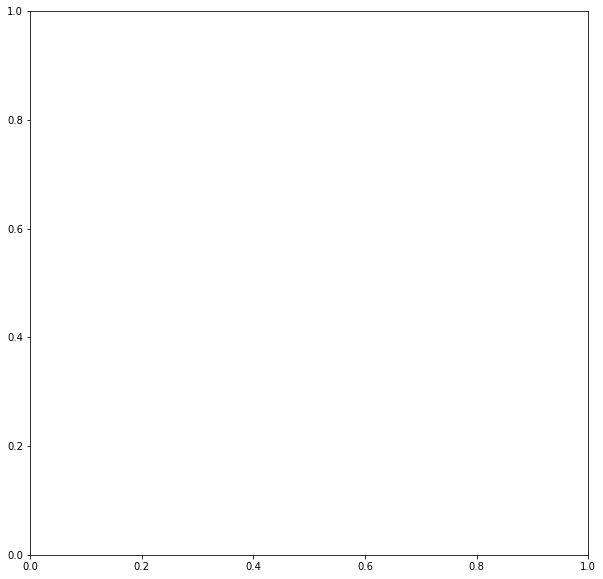

In [33]:
_, ax = plt.subplots(figsize=(10,10))
kmeansdata.plot(column='B07411_001E', ec='w', cmap='plasma', ax=ax)
plt.axis('off')
plt.savefig('agg_ca_kmeans_income.png')

### Aggregate flows

In [45]:
CAcdata = CAflows.join(CAcounties.set_index('county'), on='Res_CountyFIPS')

In [53]:
# Manually aggregate flows

flows = np.zeros((CAcdata['kmeans_labels'].unique().shape[0], CAcdata['kmeans_labels'].unique().shape[0]))
for o in range(flows.shape[0]):
    # Locate all flows origininating in region i and going to different regions    
    for r in CAcdata.loc[CAcdata['kmeans_labels'] == o].iterrows():
        dest = regionof(r[1]['Work_County'], 'kmeans')
        if o != dest: flows[o, dest] += r[1]['Flow']

## Set up variables and fit Gravity model
(oh my god it works)

In [54]:
# use aggregated centroids to create costs in Euclidean distances (do this with a spatial weight?)
coords = np.hstack((kmeansdata.centroid.x.values.reshape(-1, 1), kmeansdata.centroid.y.values.reshape(-1, 1)))
o_coords = np.repeat(coords, coords.shape[0], axis=0)
d_coords = np.tile(coords, (coords.shape[0], 1))
cost = norm(o_coords - d_coords, axis=1)

In [55]:
# set o_vars and d_vars based on aggregated matrix
basevars = kmeansdata[['B00001_001E', 'B02001_002E', 'B07411_001E']].astype(int).values
o_vars = np.repeat(basevars, basevars.shape[0], axis=0)
d_vars = np.tile(basevars, (basevars.shape[0], 1))

In [56]:
iflows = flows.astype(int).flatten()

In [57]:
model = Gravity(iflows, o_vars, d_vars, cost, 'exp')

In [58]:
model.params

array([ 7.22065685e+01,  1.79315320e+00, -1.00013126e+00, -4.53756324e+00,
        2.91262594e+00, -1.97169957e+00, -2.60298648e+00, -1.04179346e-06])

In [59]:
model.AIC

2181585.939565057

## Max-p regions (way more computationally intensive....)

In [ ]:
# Set other parameters for the regionalization solvers
top_n = 2
threshold_name = 'Flow'
threshold = CAcdata[threshold_name].sum() / 20
attrs = ['B00001_001E', 'B07411_001E']  # 'B00001_001E', 'B02001_002E', 'B07411_001E'

In [ ]:
maxp_model = MaxPHeuristic(CAcdata, Wc, attrs, threshold_name, threshold, top_n, verbose=True)
maxp_model.solve()
CAcdata['maxp_labels'] = maxp_model.labels_

In [ ]:
# Plot max-p regions spatial clustering
fig, ax = plt.subplots(figsize=(10,10))
CAcdata.plot(column='maxp_labels', categorical=True, ec='w', ax=ax)
plt.axis('off')
plt.savefig('cac_maxp.png')